# Classification Trees & Random Forest Classifier

## Libraries and settings

In [1]:
# Libraries
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

/Users/natalievintonjak/Documents/GitHub/ZHAW-Data-Science-Fundamentals/Week9


## Import the apartment data

In [3]:
# Define columns for import
columns = [ 'web-scraper-order',
            'address_raw',
            'rooms',
            'area',
            'luxurious',
            'price',
            'price_per_m2',
            'lat',
            'lon',
            'bfs_number',
            'bfs_name',
            'pop',
            'pop_dens',
            'frg_pct',
            'emp',
            'tax_income',
            'dist_supermarket']

# Read and select variables
df_orig = pd.read_csv("apartments_data_enriched.csv", sep=";", encoding='utf-8')[columns]

# Rename variable 'web-scraper-order' to 'id'
df_orig = df_orig.rename(columns={'web-scraper-order': 'id'})

# Remove missing values
df = df_orig.dropna()
df.head(5)

# Remove duplicates
df = df.drop_duplicates()

# Remove some 'extreme' values
df = df.loc[(df['price'] >= 1000) & 
            (df['price'] <= 5000)]

print(df.shape)
df.head(5)

(804, 17)


,id,address_raw,rooms,area,luxurious,price,price_per_m2,lat,lon,bfs_number,bfs_name,pop,pop_dens,frg_pct,emp,tax_income,dist_supermarket
0,1662023695-433,"Sunnenbergstrasse 15, 8633 Wolfhausen, ZH",3.5,122,1,3180,26.07,47.255714,8.804976,112,Bubikon,7344,632.558140,11.410675,3617.0,79385.90434,317.117916
1,1662023720-634,"Blumenbergstrasse 7, 8633 Wolfhausen, ZH",4.0,87,0,1690,19.43,47.254879,8.793746,112,Bubikon,7344,632.558140,11.410675,3617.0,79385.90434,612.612674
2,1662023745-834,"8608 Bubikon, ZH",3.5,92,0,2350,25.54,47.277386,8.800306,112,Bubikon,7344,632.558140,11.410675,3617.0,79385.90434,2269.090923
3,1662023701-503,"8608 Bubikon, ZH",3.5,130,0,2500,19.23,47.277386,8.800306,112,Bubikon,7344,632.558140,11.410675,3617.0,79385.90434,2269.090923
4,1662023745-820,"Lavaterstr. 63, 8002 Zürich, ZH",2.5,78,0,3760,48.21,47.361378,8.533339,261,Zürich,420217,4778.994655,32.458468,491193.0,82932.73770,349.937421


## Create new variable 'price_per_m2_class'

In [6]:
# Create labels
labels = ['0 - 19', '20 - 24', '25 - 32', '>= 33']

# Create new categorical variable
#creates a new categorical variable named "price_per_m2_class" based on the values in the 'price_per_m2' column of the DataFrame df. 
# This new categorical variable is generated by binning the values in the 'price_per_m2' column into specific ranges defined by the bins=[0, 20, 25, 33, 150]. 
# These bins define the boundaries for categorizing the values in the 'price_per_m2' column.
# Values from 0 to less than 20 fall into the category '0 - 19'.
# Values from 20 to less than 25 fall into the category '20 - 24'.
# Values from 25 to less than 33 fall into the category '25 - 32'.
# Values greater than or equal to 33 and up to 150 fall into the category '>= 33'.
# In diesem spezifischen Beispiel werden die Werte der Spalte 'price_per_m2' in Kategorien eingeteilt. Die Verwendung der Zahl 150 in den Bins (bins=[0, 20, 25, 33, 150]) dient dazu, die Grenze für die letzte Kategorie festzulegen.
df["price_per_m2_class"] = pd.cut(df['price_per_m2'], bins=[0, 20, 25, 33, 150], labels=labels)

# Check values
# displays the first 10 rows of the DataFrame df showing the columns 'price_per_m2' and 'price_per_m2_class', 
# thereby displaying the original values in the 'price_per_m2' column alongside their corresponding categorical classifications determined by the specified bins and labels.
df[['price_per_m2', 'price_per_m2_class']].head(10)

,price_per_m2,price_per_m2_class
0,26.07,25 - 32
1,19.43,0 - 19
2,25.54,25 - 32
3,19.23,0 - 19
4,48.21,>= 33
6,49.49,>= 33
7,40.04,>= 33
8,30.69,25 - 32
9,30.77,25 - 32
10,82.67,>= 33


## Classification Tree
See also: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

### Create train and test samples (train = 80%, test = 20% of the data)

In [7]:
# Create train and test samples
#Die Funktion erhält die Feature-Variablen (X) und die Zielvariable (y) als Argumente
X_train, X_test, y_train, y_test = train_test_split(df[[
                                                        ## Feature-Variablen (unabhängige Variablen)
                                                        'area', 
                                                        'rooms',
                                                        'pop_dens',
                                                        'tax_income',
                                                        'dist_supermarket']], 
                                                        # Zielvariable (abhängige Variable)
                                                        df['price_per_m2_class'], 
                                                        ## Größe des Testsets (hier 20% des Gesamtdatensatzes)
                                                        test_size=0.20, 
                                                        # Festlegen des Random Seeds für die Reproduzierbarkeit der Aufteilung
                                                        random_state=42)

# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

#Die head()-Methode wird verwendet, um nur die ersten Zeilen der Daten anzuzeigen,
#  um einen schnellen Überblick über die Struktur der Trainingsdaten und der Zielvariablen zu erhalten. 

X_train:
     area  rooms     pop_dens   tax_income  dist_supermarket
362    75    3.5  1662.597326  70118.99692        595.010106
369    90    3.5  1662.597326  70118.99692        157.537439
496   100    3.5  1327.635328  80595.52826        147.967057
349    94    3.5  1662.597326  70118.99692         52.959836
308    94    3.5  1662.597326  70118.99692         65.909235 

y_train:
362    20 - 24
369     0 - 19
496     0 - 19
349    25 - 32
308    25 - 32
Name: price_per_m2_class, dtype: category
Categories (4, object): ['0 - 19' < '20 - 24' < '25 - 32' < '>= 33']


### Fit the classification tree model

In [8]:
# Create decision tree regressor object, nicht tiefer als 3 Ebenen
clf = DecisionTreeClassifier(random_state=20, 
                             max_depth=3)

# Train decision tree regressor
#Das erstellte Classifier-Objekt (clf) wird mit den Trainingsdaten (X_train für die Features und y_train für die Zielvariablen) trainiert.
#  Der Algorithmus passt die Entscheidungsregeln des Baumes an, um die Trainingsdaten bestmöglich zu modellieren.
clf = clf.fit(X_train, y_train)

# Predict the response for test dataset
#Mit dem trainierten Modell (clf) werden Vorhersagen 
# für die unabhängigen Testdaten (X_test) gemacht, und diese Vorhersagen werden in der Variable y_pred gespeichert.
y_pred = clf.predict(X_test)

### Calculate accuracy

In [9]:
# Calculate accuracy
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred):.4f}')

Accuracy: 0.5155


### Cross validation

In [10]:
# Cross-validation (5-fold)
#Die Funktion cross_val_score führt eine k-fold Kreuzvalidierung durch. Sie verwendet den bereits trainierten Decision Tree Classifier clf, um die Genauigkeit des Modells auf den Testdaten (X_test und y_test) zu bewerten.
# Der Parameter cv=5 gibt an, dass eine 5-fache Kreuzvalidierung durchgeführt werden soll, was bedeutet, dass der Datensatz in fünf Teile aufgeteilt wird und das Modell fünfmal trainiert und getestet wird,
#Das Argument scoring='accuracy' gibt an, dass die Genauigkeit als Bewertungsmetrik für die Kreuzvalidierung verwendet wird
cv = cross_val_score(clf, 
                     X_test, 
                     y_test, 
                     cv=5, 
                     scoring='accuracy')

# Result
#Das end=" " am Ende des print-Statements gibt an, dass nach dem Ausdrucken der Ergebnisse ein Leerzeichen hinzugefügt werden soll.
print(list(cv.round(4)), end=" ")

[0.5455, 0.5312, 0.625, 0.5625, 0.5938] 

### Print text representation of the classification tree

In [11]:
# Text representation of the classification tree
#Die Funktion export_text wird verwendet, um eine textbasierte Repräsentation des Entscheidungsbaums zu erstellen, 
#der durch den trainierten Classifier clf repräsentiert wird.
#feature_names=list(X_train.columns) gibt an, dass die Namen der Features (unabhängigen Variablen), 
#die im Training verwendet wurden, verwendet werden sollen, um die Features im Entscheidungsbaum zu benennen.
text_representation = tree.export_text(clf, 
                                       feature_names=list(X_train.columns),
                                       max_depth=2)

# Print text_representation
print(text_representation)

|--- pop_dens <= 3215.98
|   |--- area <= 59.50
|   |   |--- area <= 44.50
|   |   |   |--- class: >= 33
|   |   |--- area >  44.50
|   |   |   |--- class: 25 - 32
|   |--- area >  59.50
|   |   |--- area <= 97.50
|   |   |   |--- class: 20 - 24
|   |   |--- area >  97.50
|   |   |   |--- class: 20 - 24
|--- pop_dens >  3215.98
|   |--- area <= 42.50
|   |   |--- class: >= 33
|   |--- area >  42.50
|   |   |--- area <= 98.50
|   |   |   |--- class: >= 33
|   |   |--- area >  98.50
|   |   |   |--- class: 25 - 32



### Vizualizing the classification tree

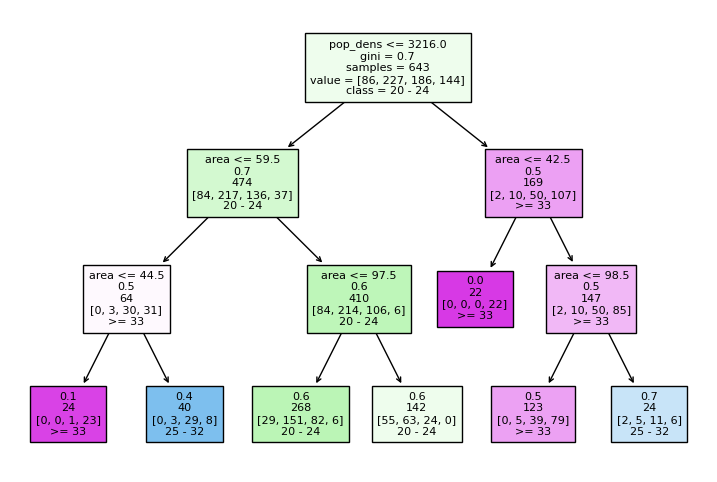

In [12]:
# For the meaning of numbers in each box, look at the root node
#    This initializes a figure with a specific size (9 units in width and 6 units in height) to hold the decision tree plot.
fig = plt.figure(figsize=(9,6))

# Plot the 
#tree.plot_tree is a method to visualize the decision tree classifier (clf) using a tree-like structure.
#feature_names=list(X_train.columns) specifies the names of the features to be displayed in the tree plot.
#class_names=['0 - 19', '20 - 24', '25 - 32', '>= 33'] provides the class labels for the different categories ('0 - 19', '20 - 24', '25 - 32', '>= 33') used in classification.
#filled=True fills the nodes with colors representing the majority class in that node.
#fontsize=8 sets the font size of the text in the plot.
#label='root' assigns the label 'root' to the root node of the tree.
#precision=1 specifies the number of decimal places to be shown in floating-point numbers in the plot.
tree_plot = tree.plot_tree(clf, 
                           feature_names=list(X_train.columns),  
                           class_names=['0 - 19', '20 - 24', '25 - 32', '>= 33'],
                           filled=True,
                           fontsize=8,
                           label='root',
                           precision=1)

## Random Forest Classifier
For details see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### Fit the Random Forest Classifier

In [13]:
# make_classification is a function from Scikit-Learn used to generate synthetic classification datasets.
    #n_features=4 specifies the number of features in the generated dataset.
    #n_informative=2 indicates the number of informative features among the total features.
    #random_state=5 and shuffle=False are parameters controlling the randomness and shuffling of the dataset.
X, y = make_classification(n_features=4, n_informative=2,
                           random_state=5, shuffle=False)

#    RandomForestClassifier is used to create an instance of the Random Forest Classifier.
    #n_estimators=500 specifies the number of trees in the forest.
    #max_depth=10 sets the maximum depth of each tree in the forest.
    #random_state=42 sets the random seed for reproducibility.
    #The classifier (clf_rf) is trained using the fit function on the training data (X_train and y_train).

clf_rf = RandomForestClassifier(n_estimators=500, 
                               max_depth=10, 
                               random_state=42)
clf_rf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf_rf.predict(X_test)


#metrics.accuracy_score is used to calculate the accuracy of the model's predictions by comparing predicted labels (y_pred) with the actual labels (y_test).
#The calculated accuracy is then printed with a precision of 4 decimal places.
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred):.4f}')

Accuracy: 0.5776


### Show feature importance

Index(['area', 'pop_dens', 'dist_supermarket', 'tax_income', 'rooms'], dtype='object')
[0.28686945 0.2277348  0.20321975 0.1414003  0.1407757 ]


<Axes: ylabel='features'>

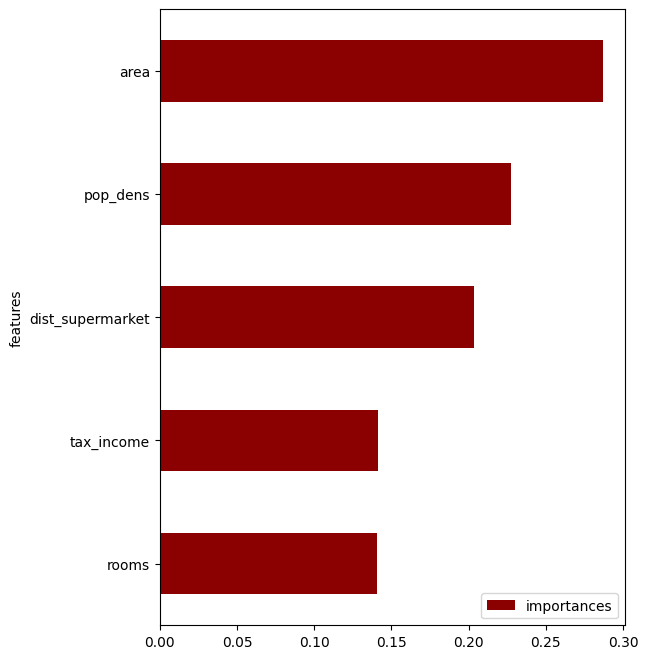

In [15]:
cols = X_train.columns

# Derive feature importance from random forest
# clf_rf.feature_importances_ retrieves the feature importances computed by the Random Forest Classifier
# np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0) calculates the standard deviation of feature importances across all trees in the forest (clf_rf.estimators_).
# np.argsort(importances)[::-1] sorts the indices of feature importances in descending order, creating a ranking of feature importance indices.
importances = clf_rf.feature_importances_
std         = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# cols[indices] prints the column names (features) in order of their importance.
# importances[indices] prints the corresponding importance values for each feature, sorted by their importance.
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
#The code creates a DataFrame (df_fi) containing feature names and their respective importances.
# The DataFrame is then sorted based on the importances.
# Finally, it generates a horizontal bar plot (kind='barh') displaying feature importances (y='importances') against feature names (x='features') using the 'darkred' color and a figure size of (6, 3).
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,8))